<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: Calwebb_coron3 for MIRI coronagraphic imaging
<span style="color:red"> **Instruments Affected**</span>: MIRI, NIRCam

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#test_descr)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Load Input Data](#data_load)
<br> [Run the Pipeline](#run_pipeline)
<br> [Examine Outputs](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for stage 3 coronagraphic processing of MIRI 4QPM exposures. The stage 3 coronagraphic pipeline ([`calwebb_coron3`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html#calwebb-coron3)) is to be applied to associations of calibrated NIRCam and MIRI coronagraphic exposures, and is used to produce PSF-subtracted, resampled, combined images of the source object. For more information on `calwebb_coron3`, please visit the links below.

> Module description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html#calwebb-coron3

> Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/coron/


[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm


The algorithms for `CALWEBB_CORON3` are as follows:

- **Assemble Reference PSFs**: <br>
All the available reference PSFs are assembled into the appropriate association.


- **Outlier detection**: <br> 
An iterative sigma clipping algorithm is used in pixel coordinates on the image stack. The presence of an outlier results in a pixel flag being set.


- **Align reference PSFs**: <br>
The reference PSFs are aligned with the target observation using the Fourier LSQ algorithm to measure the shifts and the Fourier Shift algorithm to apply the shifts to each reference PSF integration.


- **Reference PSF subtraction**: <br>
The reference PSF that is subtracted from each target integration is created using the list of reference PSFs and the KLIP algorithm. 


- **Image Combination**: <br>
The target images (including those at different rotations) are combined into a single combined image using the AstroDrizzle code (with the output pixel size set to the input pixel size).


- **Updated Exposure Level Products**: <br>
The exposure level products are re-created to provide the highest quality products that include the results of the ensemble processing (updated WCS, matching backgrounds, and 2nd pass outlier detection). 

<BR>

The current status of these algorithms are summarized in the link below:

> https://outerspace.stsci.edu/display/JWSTCC/CALWEBB_CORON3


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

- **JWST**: James Webb Space Telescope ([see documentation](https://jwst-docs.stsci.edu/))
- **MIRI**: Mid-Infrared Instrument ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument))
- **NIRCam**: Near-Infrared Instrument ([see documentation](https://jwst-docs.stsci.edu/near-infrared-camera))
- **4QPM**: 4 Quadrant Phase Mask ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-4qpm))
- **Lyot**: coronagraph design incorporating a classical Lyot spot ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-lyotcoron))
- **PanCAKE**: an in-house tool at STScI used to simulate coronagraphic PSFs 
([see documentation](https://github.com/spacetelescope/pandeia-coronagraphy))
- **SGD**: Small Grid Dither 
([see documentation](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/hci-proposal-planning/hci-small-grid-dithers))
    
    

    
 [Top of Page](#title_ID)

<a id="test_descr"></a>
# Test Description

This notebook tests the the following steps applied by `calwebb_coron3` for pipeline version == **'0.17.1'**.

 - [**stack_refs**](#stack_refs)
 - [**align_refs**](#align-refs)
 - [**klip**](#klip)

These tests are performed using simulated MIRI 4QPM coronagraphic data (see [Data Description](#data_descr)).

This notebook does not test the following steps applied by the `calwebb_coron3` pipeline:

 - **outlier_detection**
 - **resample**
 
See [Required Future Testing](#future_tests) for details.


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

### Input Data:

The set of data used in these tests were generated using `PanCAKE` and edited to enable processing through the `calwebb_coron3` pipeline. The simulated data was generated for the MIRI 1065C 4QPM coronagraph and consists of one science exposure and nine reference PSF exposures based on the following observation scenario: (1) a science observation of a target star with two faint companions, followed by (2) the execution of a 9-point small grid dither (SGD) pattern on a PSF calibrator of similar magnitude, to obtain a set of 9 slightly offset reference PSF observations.


The data has the following naming format:
- Science exposure: 

      'new_targ_0.fits' 

- Reference PSF exposures:

      'new_ref_0.fits', 'new_ref_1.fits', 'new_ref_2.fits', 'new_ref_3.fits', 'new_ref_4.fits', 'new_ref_5.fits', 'new_ref_6.fits', 'new_ref_7.fits', 'new_ref_8.fits'
      


### Refence Files:

The `align_refs` step requires a PSFMASK reference file containing a 2D mask that’s used as a weight function when computing shifts between images. 

> File description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/description.html#psfmask-reffile

Currently the PSFMASK reference files ingested into CRDS are incorrect (wrong shape and incorrectly centered around coronagraphic obstructions), therefore an updated file is used for these tests:

       'psfmask_MIRI_4QPM_1065.fits'
 

### Association File:

Currently the individual stage 3 coronagraphic processing steps can only be run in a convenient way by running the `calwebb_coron3` pipeline on an association (ASN) file that lists the various science target and reference PSF exposures to be processed. 

> Level 3 Associations documentation: https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_rules.html

We use the following ASN file for the purpose of these tests:

       'test.yml'




[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports

* `astropy.io` for opening fits files
* `jwst` is the JWST Calibration Pipeline
* `jwst.Coron3Pipeline` is the pipeline being tested
* `matplotlib.pyplot.plt` to generate plots
* `numpy` for array calculations and manipulation
* `download_file` for downloading and accessing files
* `ipywidgets`, `IPython.display.display,clear_output` to display images.
* `ci_watson.arartifactory_helpers.get_bigdata` to download data

[Top of Page](#title_ID)

In [1]:
import jwst
from jwst.pipeline import Coron3Pipeline
from astropy.io import fits
from ci_watson.artifactory_helpers import get_bigdata
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.utils.data import download_file
%config InlineBackend.close_figures=False # To prevent automatic figure display when execution of the cell ends
import numpy as np
import ipywidgets as widgets
from IPython.display import display,clear_output
import os

2021-04-23 14:35:15,577 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



In [2]:
jwst.__version__
# should out '0.17.1'

'1.1.0'

<a id="data_load"></a>
# Load Input Data

In [3]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import shutil
data_dir = TemporaryDirectory()
shutil.copy("jwst_calcoron3_miri_test.yml", os.path.join(data_dir.name, "jwst_calcoron3_miri_test.yml"))
os.chdir(data_dir.name)

In [4]:
# new PSFMASK file

psf_mask_dir = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'jwst_miri_psfmask_0001_new.fits')


In [5]:
# download science image

target_psf_fn = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_targ.fits')


In [6]:
# download PSF reference images
    
new_ref_0 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_0.fits')

new_ref_1 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_1.fits')

new_ref_2 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_2.fits')

new_ref_3 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_3.fits')

new_ref_4 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_4.fits')

new_ref_5 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_5.fits')

new_ref_6 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_6.fits')

new_ref_7 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_7.fits')
             
new_ref_8 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_coron3',
                     'coron3_miri_test', 
                     'new_ref_8.fits')

In [7]:
# Create array containing the input reference images
input_ref_images = [fits.getdata(new_ref_8)[0], fits.getdata(new_ref_7)[0], fits.getdata(new_ref_6)[0], 
                    fits.getdata(new_ref_5)[0],fits.getdata(new_ref_4)[0], fits.getdata(new_ref_3)[0], 
                    fits.getdata(new_ref_2)[0], fits.getdata(new_ref_1)[0], fits.getdata(new_ref_0)[0]]

[Top of Page](#title_ID)
<a id="run_pipeline"></a>


------------

# Run the Pipeline

In [8]:
asn_dir = 'jwst_calcoron3_miri_test.yml'                       # Define ASN file
myCoron3Pipeline = Coron3Pipeline()                              
myCoron3Pipeline.align_refs.override_psfmask = psf_mask_dir    # Override PSFMASK file
myCoron3Pipeline.resample.skip = True                          # Skip resample step
myCoron3Pipeline.save_results = True                             
myCoron3Pipeline.output_dir = os.getcwd() 
myCoron3Pipeline.run(asn_dir)                                  # run pipeline

2021-04-23 14:35:18,233 - stpipe.Coron3Pipeline - INFO - Coron3Pipeline instance created.


2021-04-23 14:35:18,234 - stpipe.Coron3Pipeline.stack_refs - INFO - StackRefsStep instance created.


2021-04-23 14:35:18,235 - stpipe.Coron3Pipeline.align_refs - INFO - AlignRefsStep instance created.


2021-04-23 14:35:18,236 - stpipe.Coron3Pipeline.klip - INFO - KlipStep instance created.


2021-04-23 14:35:18,237 - stpipe.Coron3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-04-23 14:35:18,238 - stpipe.Coron3Pipeline.resample - INFO - ResampleStep instance created.


2021-04-23 14:35:18,363 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline running with args ('jwst_calcoron3_miri_test.yml',).


2021-04-23 14:35:18,367 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'steps': {'stack_refs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'align_refs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'median_box_length': 3,

2021-04-23 14:35:18,368 - stpipe.Coron3Pipeline - INFO - Starting calwebb_coron3 ...


202104231435:DEBUG:jwst.associations.association_io.load:Error unserializing: "Expecting property name enclosed in double quotes: line 12 column 11 (char 316)"


2021-04-23 14:35:18,737 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_8.fits' reftypes = []


2021-04-23 14:35:18,738 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:18,968 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_7.fits' reftypes = []


2021-04-23 14:35:18,969 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,081 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_6.fits' reftypes = []


2021-04-23 14:35:19,082 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,193 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_5.fits' reftypes = []


2021-04-23 14:35:19,194 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,309 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_4.fits' reftypes = []


2021-04-23 14:35:19,312 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,425 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_3.fits' reftypes = []


2021-04-23 14:35:19,426 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,534 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_2.fits' reftypes = []


2021-04-23 14:35:19,535 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,644 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_1.fits' reftypes = []


2021-04-23 14:35:19,645 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:19,897 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_ref_0.fits' reftypes = []


2021-04-23 14:35:19,898 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:20,010 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'new_targ.fits' reftypes = []


2021-04-23 14:35:20,011 - stpipe.Coron3Pipeline - INFO - Override for PSFMASK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits'.


2021-04-23 14:35:21,168 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_8.fits>,).


2021-04-23 14:35:21,169 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,177 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,177 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,178 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,275 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_7.fits>,).


2021-04-23 14:35:21,277 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,284 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,285 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,285 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,380 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_6.fits>,).


2021-04-23 14:35:21,382 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,389 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,389 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,390 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,487 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_5.fits>,).


2021-04-23 14:35:21,488 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,495 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,496 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,496 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,593 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_4.fits>,).


2021-04-23 14:35:21,594 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,601 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,602 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,602 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,697 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_3.fits>,).


2021-04-23 14:35:21,699 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,705 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,706 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,706 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,800 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_2.fits>,).


2021-04-23 14:35:21,802 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,809 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,809 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,810 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:21,903 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_1.fits>,).


2021-04-23 14:35:21,905 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:21,912 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:21,912 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:21,913 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:22,007 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_ref_0.fits>,).


2021-04-23 14:35:22,009 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:22,016 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:22,016 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:22,017 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:22,110 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs running with args (<ModelContainer>,).


2021-04-23 14:35:22,111 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-23 14:35:22,117 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 1 to output stack


2021-04-23 14:35:22,118 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 2 to output stack


2021-04-23 14:35:22,119 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 3 to output stack


2021-04-23 14:35:22,120 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 4 to output stack


2021-04-23 14:35:22,121 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 5 to output stack


2021-04-23 14:35:22,122 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 6 to output stack


2021-04-23 14:35:22,123 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 7 to output stack


2021-04-23 14:35:22,125 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 8 to output stack


2021-04-23 14:35:22,126 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 9 to output stack


2021-04-23 14:35:22,145 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs done


2021-04-23 14:35:22,194 - stpipe.Coron3Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jw10005-miri-mask1065_psfstack.fits


2021-04-23 14:35:22,423 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(1, 224, 288) from new_targ.fits>,).


2021-04-23 14:35:22,424 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'c1001_crfints', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-04-23 14:35:22,431 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Input only contains 1 integration


2021-04-23 14:35:22,432 - stpipe.Coron3Pipeline.outlier_detection - WARNING - Outlier detection step will be skipped


2021-04-23 14:35:22,432 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-04-23 14:35:22,533 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs running with args (<CubeModel(1, 224, 288) from new_targ.fits>, <CubeModel(9, 224, 288) from jw10005-miri-mask1065_psfstack.fits>).


2021-04-23 14:35:22,535 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'median_box_length': 3, 'bad_bits': 'DO_NOT_USE'}


2021-04-23 14:35:22,542 - stpipe.Coron3Pipeline.align_refs - INFO - Using PSFMASK reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jwst_miri_psfmask_0001_new.fits


2021-04-23 14:35:22,576 - stpipe.Coron3Pipeline.align_refs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



2021-04-23 14:35:22,577 - stpipe.Coron3Pipeline.align_refs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)



2021-04-23 14:35:22,578 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,581 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,581 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,582 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,582 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,583 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,583 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,584 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,584 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,585 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,593 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,597 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,597 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,597 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,598 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,598 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,599 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,600 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,600 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,600 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,609 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,612 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,612 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,613 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,614 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,614 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,614 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,615 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,616 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,616 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,625 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,628 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,628 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,629 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,629 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,630 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,630 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,631 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,631 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,632 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,640 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,643 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,644 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,644 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,645 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,645 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,646 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,647 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,647 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,647 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,656 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,659 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,660 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,660 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,661 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,661 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,662 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,662 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,662 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,663 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,672 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,675 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,675 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,676 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,676 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,677 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,677 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,678 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,678 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,678 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,687 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,690 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,691 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,691 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,692 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,692 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,693 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,693 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,694 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,694 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,703 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,706 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,706 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,706 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,707 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,708 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,708 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,709 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,709 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,710 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,718 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,721 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,721 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,722 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,722 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,723 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,723 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,724 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,724 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:22,725 - stpipe.Coron3Pipeline.align_refs - WARNING - Median filter returned NaN setting value to 0.


2021-04-23 14:35:23,871 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs done


2021-04-23 14:35:23,927 - stpipe.Coron3Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/new_targ_c1001_psfalign.fits


2021-04-23 14:35:24,098 - stpipe.Coron3Pipeline.klip - INFO - Step klip running with args (<CubeModel(1, 224, 288) from new_targ.fits>, <QuadModel(1, 9, 224, 288) from new_targ_c1001_psfalign.fits>).


2021-04-23 14:35:24,099 - stpipe.Coron3Pipeline.klip - INFO - Step klip parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'truncate': 50}


2021-04-23 14:35:24,106 - stpipe.Coron3Pipeline.klip - INFO - KL transform truncation = 50


2021-04-23 14:35:24,235 - stpipe.Coron3Pipeline.klip - INFO - Step klip done


2021-04-23 14:35:24,329 - stpipe.Coron3Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/new_targ_c1001_psfsub.fits


2021-04-23 14:35:24,503 - stpipe.Coron3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-04-23 14:35:24,504 - stpipe.Coron3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-04-23 14:35:24,505 - stpipe.Coron3Pipeline.resample - INFO - Step skipped.


2021-04-23 14:35:24,506 - stpipe.Coron3Pipeline.resample - INFO - Step resample done


2021-04-23 14:35:24,589 - stpipe.Coron3Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphf6ojt9p/jw10005-miri-mask1065_i2d.fits


2021-04-23 14:35:24,589 - stpipe.Coron3Pipeline - INFO - ...ending calwebb_coron3


2021-04-23 14:35:24,590 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline done


[Top of Page](#title_ID)
<a id="testing"></a>
--------------
# Examine Output Data 




<a id="stack_refs"></a>
###  `stack_refs`:  Stack PSF References (*'_psfstack' product*)

The role of the `stack_refs` step is to stack all of the PSF reference exposures (specified in the input ASN file) into a single `CubeModel` for use by subsequent coronagraphic steps. The size of the stack should be equal to the sum of the number of integrations in each input PSF exposure.  The image data are simply copied and reformatted and should not be modified in any way.

*Output*: **3D PSF Image Stack** <br>
*File suffix*: **'_psfstack'**

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/stack_refs/index.html#stack-refs-step

In [9]:
stacked_cube_hdu = fits.open('jw10005-miri-mask1065_psfstack.fits')
ref_images = stacked_cube_hdu[1].data
print(stacked_cube_hdu.info())

Filename: jw10005-miri-mask1065_psfstack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     323   ()      
  1  SCI           1 ImageHDU        66   (288, 224, 9)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 9)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 9)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5191B]   


None


In [10]:
print("'_psfstack' data product dimensions: "+str(ref_images.shape))

'_psfstack' data product dimensions: (9, 224, 288)


In [11]:
out=widgets.Output()
button=widgets.Button(description='Next')
vbox=widgets.VBox(children=(out,button))
display(vbox)
index = 0
def click(b):
    global index
    index = index % len(ref_images)
    im = plt.imshow(ref_images[index], vmin = 0, vmax = 20,interpolation ="none") 
    index += 1 
    with out:
        clear_output(wait=True)
        plt.title('Stacked PSF image #%i' % index)
        plt.show() 
button.on_click(click)
click(None)

The `stack_psfs` step has sucessfully stacked the reference PSF exposures into a single 3D '*_psfstack*' product, with size equal to the sum of the number of integrations in each input PSF exposure *(9)*. To confirm that the image data has not been modified, the input PSF images are subtracted from each image in the stack below:

In [12]:
out=widgets.Output()
button=widgets.Button(description='Next')
vbox=widgets.VBox(children=(out,button))
display(vbox)
index = 0
def click(b):
    global index
    index = index % len(ref_images)
    im = plt.imshow(ref_images[index] - input_ref_images[index], vmin = 0, vmax = 20,interpolation ="none") 
    index += 1 
    with out:
        clear_output(wait=True)
        plt.title('Stacked PSF image - input PSF image %i' % index)
        plt.show() 
button.on_click(click)
click(None)

-----------

<a id="align_refs"></a>


### `align_refs`:  Align PSF References (*'_psfalign' product*)

The role of the `align_refs` step is to align the coronagraphic PSF images with science target images. It does so by computing the offsets between the science target and reference PSF images, and shifts the PSF images into alignment. The output of the `align_refs` step is a 4D data product, where the 3rd axis has length equal to the total number of reference PSF images in the input PSF stack and the 4th axis has length equal to the number of integrations in the input science target product. 

*Output*: **4D aligned PSF Images** <br>
*File suffix*: **_psfalign**


> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/index.html#align-refs-step

In [13]:
aligned_cube_hdu = fits.open('new_targ_c1001_psfalign.fits')
aligned_cube_hdu.info()

Filename: new_targ_c1001_psfalign.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     324   ()      
  1  SCI           1 ImageHDU        67   (288, 224, 9, 1)   float32   
  2  ERR           1 ImageHDU        12   (288, 224, 9, 1)   float32   
  3  DQ            1 ImageHDU        13   (288, 224, 9, 1)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5247B]   


In [14]:
aligned_cube_data = (aligned_cube_hdu[1].data)
print("'_psfalign' data product dimensions: " + str(aligned_cube_data.shape))

'_psfalign' data product dimensions: (1, 9, 224, 288)


In [15]:
aligned_cube_data = aligned_cube_data[0]
out=widgets.Output()
button=widgets.Button(description='Next')
vbox=widgets.VBox(children=(out,button))
display(vbox)
index = 0
def click(b):
    global index
    index = index % len(aligned_cube_data)
    im = plt.imshow(aligned_cube_data[index], vmin = 0, vmax = 20,interpolation ="none") 
    index += 1 
    with out:
        clear_output(wait=True)
        plt.title('Aligned PSF image #%i' % index)
        plt.show()
button.on_click(click)
click(None)

The `align_refs` step has successfully aligned the psf images - note the stability when clicking through the images in the cube.

The output is indeed a 4D '*_psfalign*' product, where the 3rd axis has length equal to the total number of reference images in the input PSF stack *(9)* and 4th axis equal to the number of integrations in the input science target image *(1)*. 

------------
<a id="klip"></a>
### `klip`:  Reference PSF Subtraction

The role of the `klip` step is to apply the Karhunen-Loeve Image Plane (KLIP) algorithm on the science target images, using an accompanying set of aligned reference PSF images (result of the `align_refs` step) in order to fit and subtract an optimal PSF from the science target image. The PSF fitting and subtraction is applied to each integration image independently. The output is a 3D stack of PSF-subtracted images of the science target, having the same dimensions as the input science target product.

*Output*: **3D PSF-subtracted image** <br>
*File suffix*: **_psfsub**

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/klip/index.html#klip-step


In [16]:
sub_hdu = fits.open('new_targ_c1001_psfsub.fits')
sub_hdu.info()

Filename: new_targ_c1001_psfsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     324   ()      
  1  SCI           1 ImageHDU        66   (288, 224, 1)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 1)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 1)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (288, 224, 1)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (288, 224, 1)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [20768B]   


In [17]:
subtracted_image = sub_hdu[1].data
print("Science target image dimensions: " + str(subtracted_image.shape))
print("PSF subtracted image dimensions: " + str(subtracted_image.shape))

Science target image dimensions: (1, 224, 288)
PSF subtracted image dimensions: (1, 224, 288)


Note that the PSF subtracted image has the same dimensions as the input target image.

Text(0.5, 1.0, 'PSF subtracted image')

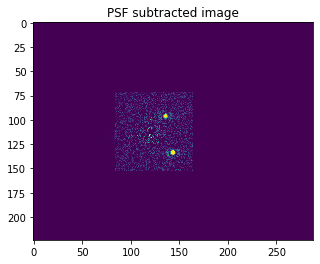

In [18]:
plt.figure()
plt.imshow(subtracted_image[0],vmin = 0, vmax = 10,interpolation ="none")
plt.title("PSF subtracted image")

The `klip` step has successfully made a synthetic psf reference image and subtracted it from the target PSF - indeed, the two companion PSFs that were injected into the target PSF are now visable. The output stack of PSF-subtracted images has the same dimensions as the input science target product.

[Top of Page](#title_ID)
<br>
<a id="future_tests"></a>
--------------
# Required Future Testing

- Testing of the `outlier_detection` step in conjunction with the three steps above.
- Testing of the `resample` step using a data set containing a reference PSF target with astrophysical contamination (i.e. a companion) and target images at two different orientations (simulating referenced differential imaging) - whereby the the `resample` step should correctly combine the two PSF-subtracted target images based on the WCS information. 
- Testing for LYOT, 1140C/FQPM and 1550C/FQPM datasets (using the updated PSFMASK Reference Files provided).
- Testing of multiple integration images (current dataset treated as only single integration images).
- Testing of data that has been processed through stage 1 and 2 pipeline modules.

[Top of Page](#title_ID)

--------------------

<a id="about"></a>
## About this Notebook
**Author:** Bryony F. Nickson (Staff Scientist, *MIRI Branch*) & J. Brendan Hagan.
<br> **Updated On:** 12/26/2020

[Top of Page](#title_ID)